In [52]:
import pickle
import yaml
import pandas as pd
import pickle
import sys
import numpy as np

import matplotlib.pyplot as plot

In [53]:
def loadConfig():    
    with open('./light_config.yaml', "r") as ymlfile: #hulk, slowloris; GE, heartbleed, slowhttp
        cfg = yaml.load(ymlfile)
    return cfg

config = loadConfig()

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
import math

def calculateFalsePositives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsepositives = []
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fp_count = 0 # add
    tp_count = 0 # add
    truepos = [] # add
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agtIPList: # add
            fp_count = fp_count + 1 # add
        if IP + IPD in agt_attacks:
            tp_count = tp_count + 1            
            
        index = index + 1
        if index in cutOff :
            falsepositives.append(fp_count/numNormal)
            truepos.append(tp_count / len(agt_attacks)) #len(agt_attacks)) # add
            
    return falsepositives, truepos

def calc_eval(fpr, tpr, agt_norm, agt_attk):
    fpr = np.array(fpr[1:])
    tpr = np.array(tpr)

    Total = len(agt_norm)+len(agt_attk) #len(userScoreP)
    TotalN = len(agt_norm)
    TotalP = Total-TotalN
    FP = fpr*TotalN
    TN = TotalN - FP
    TP = tpr*TotalP
    FN = TotalP-TP
    
    Accr = (TP+TN) / (TP+TN+FP+FN)
    FPR = FP / (FP + TN)
    Prec = TP / (TP + FP)
    Rec = TP / (TP + FN)
    F1 = 2 * ((Prec*Rec) / (Prec+Rec))

    return (Accr, FPR, Prec, Rec, F1)

# def plotAndSaveGraph(PQ, P, PQTil, classifier_rejectthres, fp_classifier, iter_classifier_one, iter_classifier, config, plt=False):
#     percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

#     plot.rcParams['figure.figsize'] = [9, 9]
#     fig = plot.figure()
#     ax = plot.subplot(111)
#     ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
#     ax.plot(percentages, P, linewidth=2, linestyle='--', markersize=9, label = "N Only")
#     ax.plot(percentages, PQ, linewidth=2, linestyle=':', markersize=9, label = "N/D (ℓ=1)") #With Transfer")
#     ax.plot(percentages, PQTil, linewidth=2, linestyle='-.', markersize=9, label = "N/D (ℓ=∞)") #Without Transfer") 
#     ax.plot(percentages, iter_classifier_one, linewidth=2, linestyle='--', marker='o', markersize=9, label = "Iter. Classifier (ℓ=1)") #Without Transfer")
#     ax.plot(percentages, iter_classifier, linewidth=2, linestyle='--', marker='s', markersize=9, label = "Iter. Classifier (ℓ=∞)") #Without Transfer")
# #     ax.plot(classifier_rejectthres,fp_classifier,'rx',markersize=15,markeredgewidth=5, label = "Full Classifier") 
    
#     ax.tick_params(axis='both', which='major', labelsize=15)
#     ax.legend(fontsize=18)
#     if plt:
#         plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPGraph')

In [55]:
def plotAndSaveGraph(P, PQ_online, PQ_offline, iter_one, iter_offline, config, plt=False, metric=None):
    percentages = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    plot.rcParams['figure.figsize'] = [9, 9]
    fig = plot.figure()
    ax = plot.subplot(111)
    ax.plot(percentages, percentages, linewidth=2, label = "Randomized Rejection")
#     ax.plot(percentages, P, linewidth=2, linestyle=':', markersize=9, label = "N Only")
    ax.plot(percentages, PQ_online, linewidth=2, linestyle='--', markersize=9, label = "Enhanced N/D (ℓ=1)") #With Transfer")
    ax.plot(percentages, PQ_offline, linewidth=2, linestyle='-.', markersize=9, label = "N/D (ℓ=1)") #Without Transfer") 
    ax.plot(percentages, iter_one, linewidth=2, linestyle='--', marker='o', markersize=9, label = "Enhanced Iter. (ℓ=1)") #Without Transfer")
    ax.plot(percentages, iter_offline, linewidth=2, linestyle='--', marker='s', markersize=9, label = "Iter. Classifier (ℓ=1)") #(ℓ=∞)
    
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=18)
    if plt:
        if metric == 'F_pos':
            plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FPos-Graph')
        if metric == 'F_neg':
            plot.savefig(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_FNeg-Graph')

### Test set

In [56]:
# #Load User Scores
userScoreP = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PScore', 'rb'))
userScoreP = userScoreP.sort_values(by = ['P'],ascending=True) # add

userScorePQ_online = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQonline_score', 'rb'))
userScorePQ_online = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=True) # add 

userScorePQ_offline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'PoverQoffline_score', 'rb'))
userScorePQ_offline = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=True) 

# userScoreQonline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'onlineQ', 'rb'))
# userScoreQonline = userScoreQonline.sort_values(by = ['QWithT'],ascending=True)

# userScoreQoffline = pickle.load(open(config['metadata']['uniqueID'] + '/' + config['metadata']['artefact'] + '/' + 'offlineQ', 'rb'))
# userScoreQoffline = userScoreQoffline.sort_values(by = ['QWithoutT'],ascending=True)

print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  12506


In [57]:
len(userScoreP)

12506

In [58]:
sum(userScoreP['Source IP'] == '999.16.30.0')

10000

In [59]:
import matplotlib.pyplot as plt
# attacker='172.16.0.1'; victim='192.168.10.50' # original attacker
attacker='999.16.30.0'; victim='999.16.30.1' # mimic attacker

# def showscore(scoretype, scores):
#     fig = plt.figure(figsize=(7,5))
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == victim], bins=20, alpha=0.5, label='victim') 
#     plt.hist(scoretype[scores].sort_values()[scoretype['Source IP'] == attacker], bins=20, alpha=0.5, label='attcker')
#     plt.legend(loc='upper right')
#     plt.show()
def showscore(scoretype, scores):
    fig = plt.figure(figsize=(7,5))
    plt.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, alpha=0.5, label='victim') 
    plt.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, alpha=0.5, label='attcker')
    plt.legend(loc='upper right')
    plt.show()
    return fig

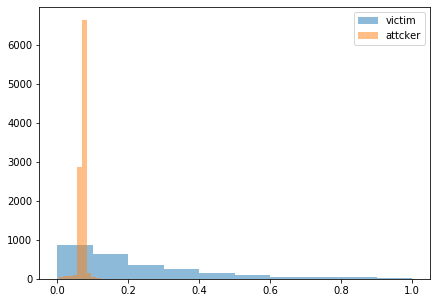

In [60]:
# add standardization
std_userScoreP = userScoreP
std_userScoreP['P'] = (std_userScoreP['P'] - std_userScoreP['P'].min(axis=0)) / (std_userScoreP['P'].max(axis=0) - std_userScoreP['P'].min(axis=0))

fig = showscore(userScoreP, 'P') # P scores

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_P_distr' + '.png')

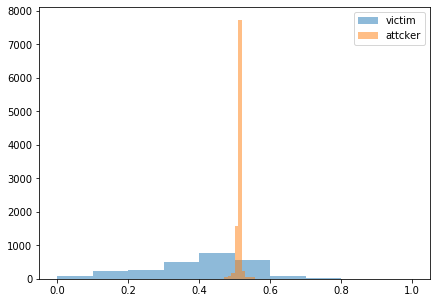

In [61]:
# add standardization
std_userScorePQ_online = userScorePQ_online
std_userScorePQ_online['PoverQ_online'] = (std_userScorePQ_online['PoverQ_online'] - std_userScorePQ_online['PoverQ_online'].min(axis=0)) / (std_userScorePQ_online['PoverQ_online'].max(axis=0) - std_userScorePQ_online['PoverQ_online'].min(axis=0))

fig = showscore(std_userScorePQ_online, 'PoverQ_online') # online Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQonline_distr' + '.png')

In [62]:
config['metadata']['uniqueID'] + '/' + config['metadata']['result'] 

'ids_test3/result/test2_loiceval1'

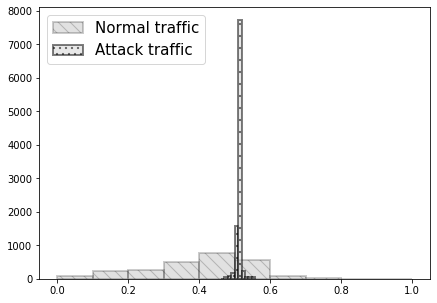

In [63]:
scoretype=std_userScorePQ_online; scores='PoverQ_online'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper left',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_NDonline_distr' + '.png')

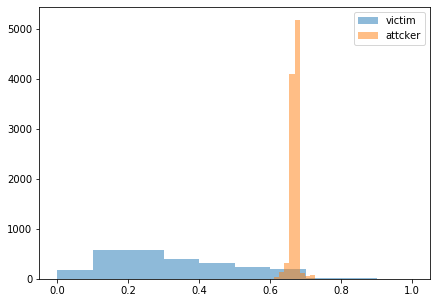

In [64]:
# add standardization
std_userScorePQ_offline = userScorePQ_offline
std_userScorePQ_offline['PoverQ_offline'] = (std_userScorePQ_offline['PoverQ_offline'] - std_userScorePQ_offline['PoverQ_offline'].min(axis=0)) / (std_userScorePQ_offline['PoverQ_offline'].max(axis=0) - std_userScorePQ_offline['PoverQ_offline'].min(axis=0))

fig = showscore(std_userScorePQ_offline, 'PoverQ_offline') # offline Q

# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_PQoffline_distr' + '.png')

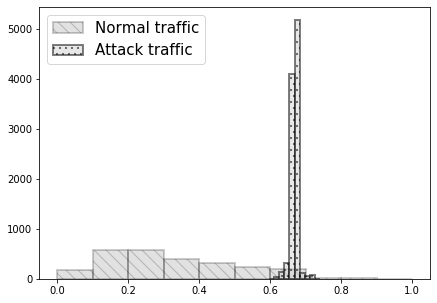

In [65]:
scoretype=std_userScorePQ_offline; scores='PoverQ_offline'


fig, ax = plt.subplots(1, figsize=(7,5))
 
# ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
# ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, range=[0.1,1], edgecolor='black', linewidth=2, alpha=0.4, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)
ax.hist(scoretype[scores][scoretype['Source IP'] != attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.2, label='Normal traffic', color = "dimgray", hatch=2*'\\', fill=True) 
ax.hist(scoretype[scores][scoretype['Source IP'] == attacker], bins=10, edgecolor='black', linewidth=2, alpha=0.5, label='Attack traffic', color = "lightgray", hatch=2*'.', fill=True)

ax.legend(loc='upper left',prop={"size":15})

plt.show()


# fig.savefig('./' + config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + '_NDoffline_distr' + '.png')

### Predicted P-only user scores

In [66]:
print("Length of userScoreP: ", len(userScoreP))

Length of userScoreP:  12506


In [67]:
agt_normals = []
agt_attacks = []
# attacker='172.16.0.1'; victim='192.168.10.50'
attacker1='999.16.30.0'; victim='999.16.30.1' #'192.168.10.50'
print("Length of userScoreP: ", len(userScoreP))

for (IP, IPD, score) in list(userScoreP.itertuples(index=False, name=None)):
#     if (IP != '172.16.0.1' and  IPD=='192.168.10.50') or IP == '192.168.10.50': 
#     if (IP != attacker and  IPD==victim) or IP == victim: 
    if IP == attacker or IP == victim:
        agt_attacks.append(IP+IPD)
    else:
        agt_normals.append(IP + IPD)
        

print("Length of Normal traffic: ", len(agt_normals))
print("Length of true attacks: ", len(agt_attacks))

#Plot some graphs
percentages = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

num = len(agt_normals)
print("Percent attacks: ", len(agt_attacks)/len(userScoreP))

Length of userScoreP:  12506
Length of Normal traffic:  2506
Length of true attacks:  10000
Percent attacks:  0.7996161842315689


In [68]:
''' Countermeasure!!!! '''

# HULK
# Length of test data:  11710
# Number of normal traffic:  4552
# Number of true attacks:  7158
# Percent attacks:  0.611272416737831

classifier_rejectthres = 0.6 #0.5099
fp_classifier = 0.028119507908611598 #0.007249560632688928

# Mimic results (FPR)
# (ℓ = ∞)
iter_classifier = [0,
 0.0003990422984836393,
 0.10814046288906624,
 0.20989624900239426,
 0.21787709497206703,
 0.22585794094173983,
 0.23822825219473265,
 0.24221867517956902,
 0.25139664804469275,
 0.26895450917797287,
 1.0]

# (ℓ = 1)
iter_classifier_one = [0,
 0.11053471667996807,
 0.21787709497206703,
 0.2916999201915403,
 0.3547486033519553,
 0.4030327214684757,
 0.4493216280925778,
 0.5079808459696727,
 0.573024740622506,
 0.6931364724660815,
 1.0]

In [69]:
''' Countermeasure!!!! '''
# Mimic results (FNR)
# (ℓ = ∞)
iter_offline_fnr = [0, 0.7092, 0.7294, 0.7428, 0.7556, 0.7689, 0.7822, 0.8038, 0.9265, 1.0, 1.0]

# (ℓ = 1)
iter_one_fnr = [0,
 0.1939,
 0.2869,
 0.3548,
 0.4202,
 0.4854,
 0.5497,
 0.6267,
 0.7234,
 0.8945,
 1.0]

In [70]:
graphP, P_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScoreP, percentages, num)
graphPQ_online, onlinePQ_tpr = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_online, percentages, num)
graphPQ_offline, offlinePQ_tpr  = calculateFalsePositives(agt_normals, agt_attacks, userScorePQ_offline, percentages, num)
# graphQonline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQonline, percentages, num)
# graphQoffline, _ = calculateFalsePositives(agt_normals, agt_attacks, userScoreQoffline, percentages, num)   

graphP.insert(0, 0)
graphPQ_online.insert(0, 0)
graphPQ_offline.insert(0, 0)
# graphQonline.insert(0, 0)
# graphQoffline.insert(0, 0)

In [71]:
''' No countermeasure!!!! '''
atkFPR_PQonline = [0, 0.485014774166315, 0.695652173913043, 0.72055719712959, 0.730688054031237, 0.738286196707471, 0.750949767834529, 0.768256648374842, 0.778809624314057, 0.797804981004643, 1.0]

atkFPR_iter_one = [0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.8335993615323224,
 0.8335993615323224,
 0.8363926576217079,
 0.8363926576217079,
 1.0,
 1.0]

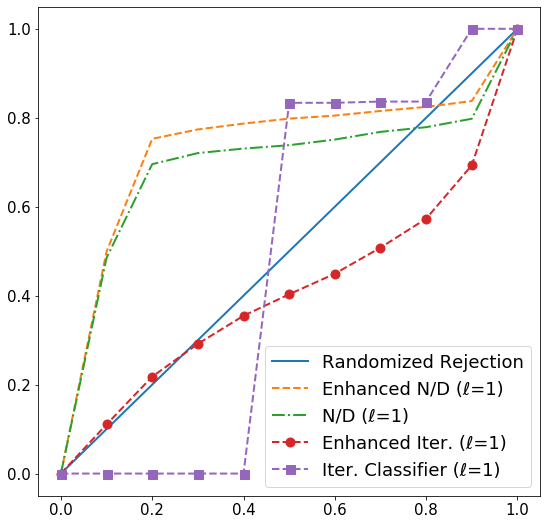

In [73]:
# plotAndSaveGraph(graphPQ_online, graphP, graphPQ_offline, classifier_rejectthres, fp_classifier, 
#                  iter_classifier_one, iter_classifier, config) #, plt=True)

plotAndSaveGraph(graphP, graphPQ_online, atkFPR_PQonline, 
                 iter_classifier_one, atkFPR_iter_one, config) #, plt=True, metric='F_pos')

### Calculate False Negatives

In [74]:
def calculateFalseNegatives(agtIPList, agt_attacks, scoreDict, percentages, numNorm) :
    numNormal = numNorm
    numTotalIP = len(scoreDict)
    cutOff = []
    falsenegatives = [] #ADD
    
    for percent in percentages :
        cutOff.append(math.ceil(numTotalIP * percent))
    
    index = 0
    fn_count = 0 #ADD
    
    for (IP, IPD, score) in list(scoreDict.itertuples(index=False, name=None)):
        if IP + IPD in agt_attacks: # ADD
            fn_count = fn_count + 1 # ADD
            
        index = index + 1
        if index in cutOff :
            falsenegatives.append(fn_count/len(agt_attacks)) #numNormal) # ADD
            
    return falsenegatives

In [75]:
# #Inverse User Scores
userScoreP_inv = userScoreP.sort_values(by = ['P'],ascending=False) # add
# userScoreP_inv
userScorePQ_online_inv = userScorePQ_online.sort_values(by = ['PoverQ_online'],ascending=False) # add 
userScorePQ_offline_inv = userScorePQ_offline.sort_values(by = ['PoverQ_offline'],ascending=False) 

print("Length of userScoreP: ", userScoreP_inv[:5]) #len(userScoreP))

Length of userScoreP:             Source IP         Dest IP         P
274    43.253.46.117    192.168.10.9  1.000000
2343   43.253.46.117    192.168.10.9  1.000000
12366  192.168.10.17  192.168.10.255  0.994954
2135   192.168.10.12    62.241.12.20  0.992910
6740   192.168.10.12    62.241.12.20  0.992910


In [76]:
graphP_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScoreP_inv, percentages, num)
graphPQ_online_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScorePQ_online_inv, percentages, num)
graphPQ_offline_fnr = calculateFalseNegatives(agt_normals, agt_attacks, userScorePQ_offline_inv, percentages, num)


graphP_fnr.insert(0, 0)
graphPQ_online_fnr.insert(0, 0)
graphPQ_offline_fnr.insert(0, 0)

In [77]:
print(graphP_fnr)
print(graphPQ_online_fnr)
print(graphPQ_offline_fnr)

[0, 0.0, 0.0588, 0.175, 0.2964, 0.4186, 0.5405, 0.663, 0.7857, 0.909, 1.0]
[0, 0.0844, 0.2062, 0.3289, 0.4514, 0.5747, 0.697, 0.8188, 0.9385, 1.0, 1.0]
[0, 0.1207, 0.2458, 0.3707, 0.4944, 0.6185, 0.743, 0.8671, 0.9857, 1.0, 1.0]


In [79]:
''' No countermeasure!!!!! '''
atkFNR_PQonline = [0, 0.0762, 0.1965, 0.3189, 0.4399, 0.5619, 0.6852, 0.8079, 0.9269, 1, 1]

atkFNR_iter_one = [0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]

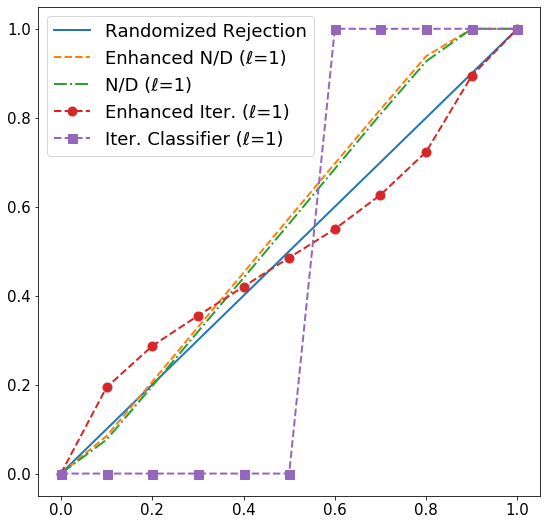

In [82]:
plotAndSaveGraph(graphP_fnr, graphPQ_online_fnr, atkFNR_PQonline, 
                 iter_one_fnr, atkFNR_iter_one, config) #, plt=True, metric='F_neg')

### Calculate evaluation metrics 

In [83]:
P_metrics = np.array(np.transpose(calc_eval(graphP, P_tpr, agt_normals, agt_attacks)))
P_metrics = np.concatenate((P_metrics, np.reshape(graphP_fnr[1:], (-1, 1))), axis=1)

onlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_online, onlinePQ_tpr, agt_normals, agt_attacks)))
onlinePQ_metrics = np.concatenate((onlinePQ_metrics, np.reshape(graphPQ_online_fnr[1:], (-1, 1))), axis=1)

offlinePQ_metrics = np.array(np.transpose(calc_eval(graphPQ_offline, offlinePQ_tpr, agt_normals, agt_attacks)))
offlinePQ_metrics = np.concatenate((offlinePQ_metrics, np.reshape(graphPQ_offline_fnr[1:], (-1, 1))), axis=1)


P_metrics = pd.DataFrame(P_metrics, columns=['Accr_P', 'FPR_P', 'Prec_P', 'Rec_P', 'F1_P', 'FNR_P'])
onlinePQ_metrics = pd.DataFrame(onlinePQ_metrics, columns=['Accr_onPQ', 'FPR_onPQ', 
                                                           'Prec_onPQ', 'Rec_onPQ', 'F1_onPQ', 'FNR_onPQ'])
offlinePQ_metrics = pd.DataFrame(offlinePQ_metrics, columns=['Accr_offPQ', 'FPR_offPQ', 
                                                             'Prec_offPQ', 'Rec_offPQ', 'F1_offPQ', 'FNR_offPQ'])
df_FPresults = pd.concat([P_metrics,onlinePQ_metrics,offlinePQ_metrics],axis=1)

/home/wesleyjtann/miniconda3/envs/ddos/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


In [84]:
df_FPresults

,Accr_P,FPR_P,Prec_P,Rec_P,F1_P,FNR_P,Accr_onPQ,FPR_onPQ,Prec_onPQ,Rec_onPQ,F1_onPQ,FNR_onPQ,Accr_offPQ,FPR_offPQ,Prec_offPQ,Rec_offPQ,F1_offPQ,FNR_offPQ
0,0.246042,0.135674,0.728217,0.0911,0.161941,0.0000,0.100352,0.499202,0.000000,0.0000,NaN,0.0844,0.100352,0.499202,0.000000,0.0000,NaN,0.1207
1,0.343195,0.142857,0.856914,0.2144,0.342985,0.0588,0.098833,0.752594,0.246203,0.0616,0.098544,0.2062,0.023349,0.940942,0.057554,0.0144,0.023036,0.2458
2,0.439469,0.152035,0.898454,0.3371,0.490256,0.1750,0.190309,0.773743,0.483209,0.1813,0.263671,0.3289,0.113066,0.966480,0.354478,0.1330,0.193426,0.3707
3,0.535343,0.162410,0.918649,0.4596,0.612677,0.2964,0.285063,0.786911,0.605836,0.3031,0.404053,0.4514,0.211498,0.970471,0.513892,0.2571,0.342731,0.4944
4,0.630178,0.175180,0.929794,0.5814,0.715437,0.4186,0.380537,0.798085,0.680154,0.4253,0.523350,0.5747,0.310491,0.972865,0.610107,0.3815,0.469452,0.6185
5,0.725732,0.186353,0.937767,0.7037,0.804045,0.5405,0.477851,0.804868,0.731210,0.5487,0.626942,0.6970,0.409084,0.976457,0.673907,0.5057,0.577811,0.7430
6,0.819846,0.201117,0.942433,0.8251,0.879872,0.6630,0.573725,0.815243,0.766648,0.6712,0.715756,0.8188,0.506877,0.982043,0.718903,0.6294,0.671181,0.8671
7,0.905725,0.236233,0.940830,0.9413,0.941065,0.7857,0.669998,0.824421,0.793503,0.7939,0.793702,0.9385,0.606669,0.982442,0.753923,0.7543,0.754111,0.9857
8,0.899568,0.501197,0.888415,1.0000,0.940911,0.9090,0.764753,0.837590,0.813522,0.9157,0.861592,1.0000,0.706701,0.982442,0.781272,0.8794,0.827437,1.0000
9,0.799616,1.000000,0.799616,1.0000,0.888652,1.0000,0.799616,1.000000,0.799616,1.0000,0.888652,1.0000,0.799616,1.000000,0.799616,1.0000,0.888652,1.0000


In [86]:
# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_allPQresults.csv", index=False)

# Rows 3=0.4, 4=0.5, 5=0.6
df_FPresults#.iloc[4]

,Accr_P,FPR_P,Prec_P,Rec_P,F1_P,FNR_P,Accr_onPQ,FPR_onPQ,Prec_onPQ,Rec_onPQ,F1_onPQ,FNR_onPQ,Accr_offPQ,FPR_offPQ,Prec_offPQ,Rec_offPQ,F1_offPQ,FNR_offPQ
0,0.246042,0.135674,0.728217,0.0911,0.161941,0.0000,0.100352,0.499202,0.000000,0.0000,NaN,0.0844,0.100352,0.499202,0.000000,0.0000,NaN,0.1207
1,0.343195,0.142857,0.856914,0.2144,0.342985,0.0588,0.098833,0.752594,0.246203,0.0616,0.098544,0.2062,0.023349,0.940942,0.057554,0.0144,0.023036,0.2458
2,0.439469,0.152035,0.898454,0.3371,0.490256,0.1750,0.190309,0.773743,0.483209,0.1813,0.263671,0.3289,0.113066,0.966480,0.354478,0.1330,0.193426,0.3707
3,0.535343,0.162410,0.918649,0.4596,0.612677,0.2964,0.285063,0.786911,0.605836,0.3031,0.404053,0.4514,0.211498,0.970471,0.513892,0.2571,0.342731,0.4944
4,0.630178,0.175180,0.929794,0.5814,0.715437,0.4186,0.380537,0.798085,0.680154,0.4253,0.523350,0.5747,0.310491,0.972865,0.610107,0.3815,0.469452,0.6185
5,0.725732,0.186353,0.937767,0.7037,0.804045,0.5405,0.477851,0.804868,0.731210,0.5487,0.626942,0.6970,0.409084,0.976457,0.673907,0.5057,0.577811,0.7430
6,0.819846,0.201117,0.942433,0.8251,0.879872,0.6630,0.573725,0.815243,0.766648,0.6712,0.715756,0.8188,0.506877,0.982043,0.718903,0.6294,0.671181,0.8671
7,0.905725,0.236233,0.940830,0.9413,0.941065,0.7857,0.669998,0.824421,0.793503,0.7939,0.793702,0.9385,0.606669,0.982442,0.753923,0.7543,0.754111,0.9857
8,0.899568,0.501197,0.888415,1.0000,0.940911,0.9090,0.764753,0.837590,0.813522,0.9157,0.861592,1.0000,0.706701,0.982442,0.781272,0.8794,0.827437,1.0000
9,0.799616,1.000000,0.799616,1.0000,0.888652,1.0000,0.799616,1.000000,0.799616,1.0000,0.888652,1.0000,0.799616,1.000000,0.799616,1.0000,0.888652,1.0000


In [ ]:
# reject 50%
df_FPresults.iloc[4]

### Calculate evaluation metrics 

In [ ]:
fpr=graphP; tpr=P_tpr
# fpr=graphPQ_online; tpr=onlinePQ_tpr
# fpr=graphPQ_offline; tpr=offlinePQ_tpr

In [ ]:
tau = 5 #3=0.4, 4=0.5, 5=0.6
fpr = np.array(fpr[1:])
tpr = np.array(tpr)

Total = len(agt_normals)+len(agt_attacks) #len(userScoreP)
TotalN = len(agt_normals)
TotalP = Total-TotalN
FP = fpr*TotalN
TN = TotalN - FP
TP = tpr*TotalP
FN = TotalP-TP

print(Total, TotalN, TotalP, FP[tau], TN[tau], TP[tau], FN[tau])

In [ ]:
Accr = (TP+TN) / (TP+TN+FP+FN)
FPR = FP / (FP + TN)
Prec = TP / (TP + FP)
Rec = TP / (TP + FN)
F1 = 2 * ((Prec*Rec) / (Prec+Rec))

print(Accr[tau], FPR[tau], Prec[tau], Rec[tau], F1[tau])

In [ ]:
graphP = np.array(graphP)
graphPQ= np.array(graphPQ_online)
graphPQTil= np.array(graphPQ_offline)

df_FPresults = pd.DataFrame({"P_FP":graphP[1:], "OnlineQ_FP":graphPQ[1:], "OfflineQ_FP":graphPQTil[1:], 
                             "Accr":Accr, "FPR":FPR, "Precision":Prec, 
                             "Recall":Rec, "F1_score":F1})

# df_FPresults.to_csv(config['metadata']['uniqueID'] + '/' + config['metadata']['result'] + 
#                     "_FPresults.csv", index=False)

In [ ]:
df_FPresults